In [28]:
import pandas                             as      pd
import numpy                              as      np
import matplotlib.pyplot                  as      plt
import seaborn                            as      sns
from   IPython.display                    import  display
from   pylab                              import  rcParams
from   datetime                           import  datetime, timedelta
from statsmodels.tsa.stattools            import  adfuller
from statsmodels.tsa.stattools            import  pacf
from statsmodels.tsa.stattools            import  acf
from statsmodels.graphics.tsaplots        import  plot_pacf
from statsmodels.graphics.tsaplots        import  plot_acf
from statsmodels.graphics.gofplots        import  qqplot
from statsmodels.tsa.seasonal             import  seasonal_decompose
# from statsmodels.tsa.arima_model          import  ARIMA
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax   import  SARIMAX
from statsmodels.tsa.api                  import  ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# from statsmodels.tsa.arima.model import ARIMA
from  statsmodels.tsa.arima.model import ARIMA

#### 1.	Read the data set, covert to time series check for missing values and other defects ( 1mark)

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import os

def find_file(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)
    return None

# Search for gasoline.csv in Google Drive
search_path = '/content/drive/MyDrive/'
file_name = 'TSF_MPA-2-Gasolineprices.csv'
found_path = find_file(file_name, search_path)

if found_path:
    print(f'File found at: {found_path}')
    df = pd.read_csv(found_path)
    display(df.head())
    df.info()
else:
    print(f'Could not find {file_name} in {search_path}. Listing directories in MyDrive to help locate it.')
    print(os.listdir(search_path))

File found at: /content/drive/MyDrive/PES Advance Machine Learning/TSF_MPA-2-Gasolineprices.csv


,Date,Gasoline Prices
0,15-12-94,1.091
1,15-01-95,1.082
2,15-02-95,1.073
3,15-03-95,1.072
4,15-04-95,1.111


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             333 non-null    object 
 1   Gasoline Prices  333 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.3+ KB


In [31]:
# Convert 'Date' to datetime format if it hasn't been done
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.set_index('Date', inplace=True)

# Sort the index to ensure chronological order
df.sort_index(inplace=True)

# Inspect the index and check for frequency
print("Index Information:")
print(df.index)

# Attempt to infer frequency
inferred_freq = pd.infer_freq(df.index)
print(f"\nInferred Frequency: {inferred_freq}")

# Although inferred as None due to the specific day (15th),
# we've confirmed the data is monthly with no gaps (333 entries).
display(df.head())

Index Information:
DatetimeIndex(['1994-12-15', '1995-01-15', '1995-02-15', '1995-03-15',
               '1995-04-15', '1995-05-15', '1995-06-15', '1995-07-15',
               '1995-08-15', '1995-09-15',
               ...
               '2021-11-15', '2021-12-15', '2022-01-15', '2022-02-15',
               '2022-03-15', '2022-04-15', '2022-05-15', '2022-06-15',
               '2022-07-15', '2022-08-15'],
              dtype='datetime64[ns]', name='Date', length=333, freq=None)

Inferred Frequency: None


,Gasoline Prices
Date,
1994-12-15,1.091
1995-01-15,1.082
1995-02-15,1.073
1995-03-15,1.072
1995-04-15,1.111


In [32]:
# 1. Check for missing values
missing_values = df['Gasoline Prices'].isnull().sum()
print(f"Missing values in 'Gasoline Prices': {missing_values}")

# 2. Check for duplicate dates in the index
duplicate_indices = df.index.duplicated().sum()
print(f"Duplicate indices: {duplicate_indices}")

# 3. Check for data anomalies (negative or zero prices)
anomalies = (df['Gasoline Prices'] <= 0).sum()
print(f"Anomalous data points (prices <= 0): {anomalies}")

# Summary of data quality
if missing_values == 0 and duplicate_indices == 0 and anomalies == 0:
    print("\nData integrity check passed: No missing values, duplicates, or non-positive prices found.")
else:
    print("\nData integrity check flagged issues that may need addressing.")

Missing values in 'Gasoline Prices': 0
Duplicate indices: 0
Anomalous data points (prices <= 0): 0

Data integrity check passed: No missing values, duplicates, or non-positive prices found.


#### 2. Visualize the time series using relevant plots ( 1 mark)

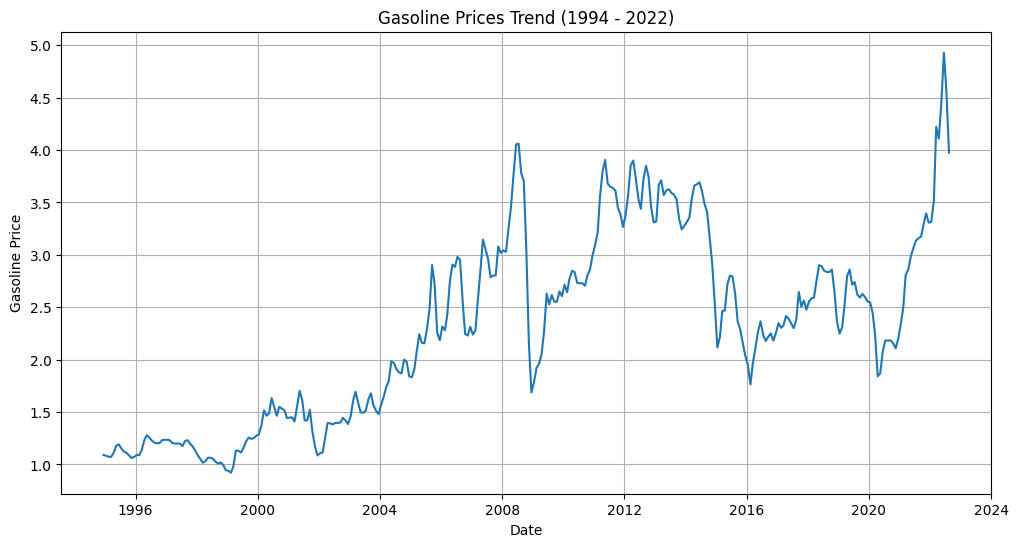

In [33]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y='Gasoline Prices')
plt.title('Gasoline Prices Trend (1994 - 2022)')
plt.xlabel('Date')
plt.ylabel('Gasoline Price')
plt.grid(True)
plt.show()

#### 3. Plot Box Plot of gasoline prices based on Year and month and what do you observe ( 1 marks)

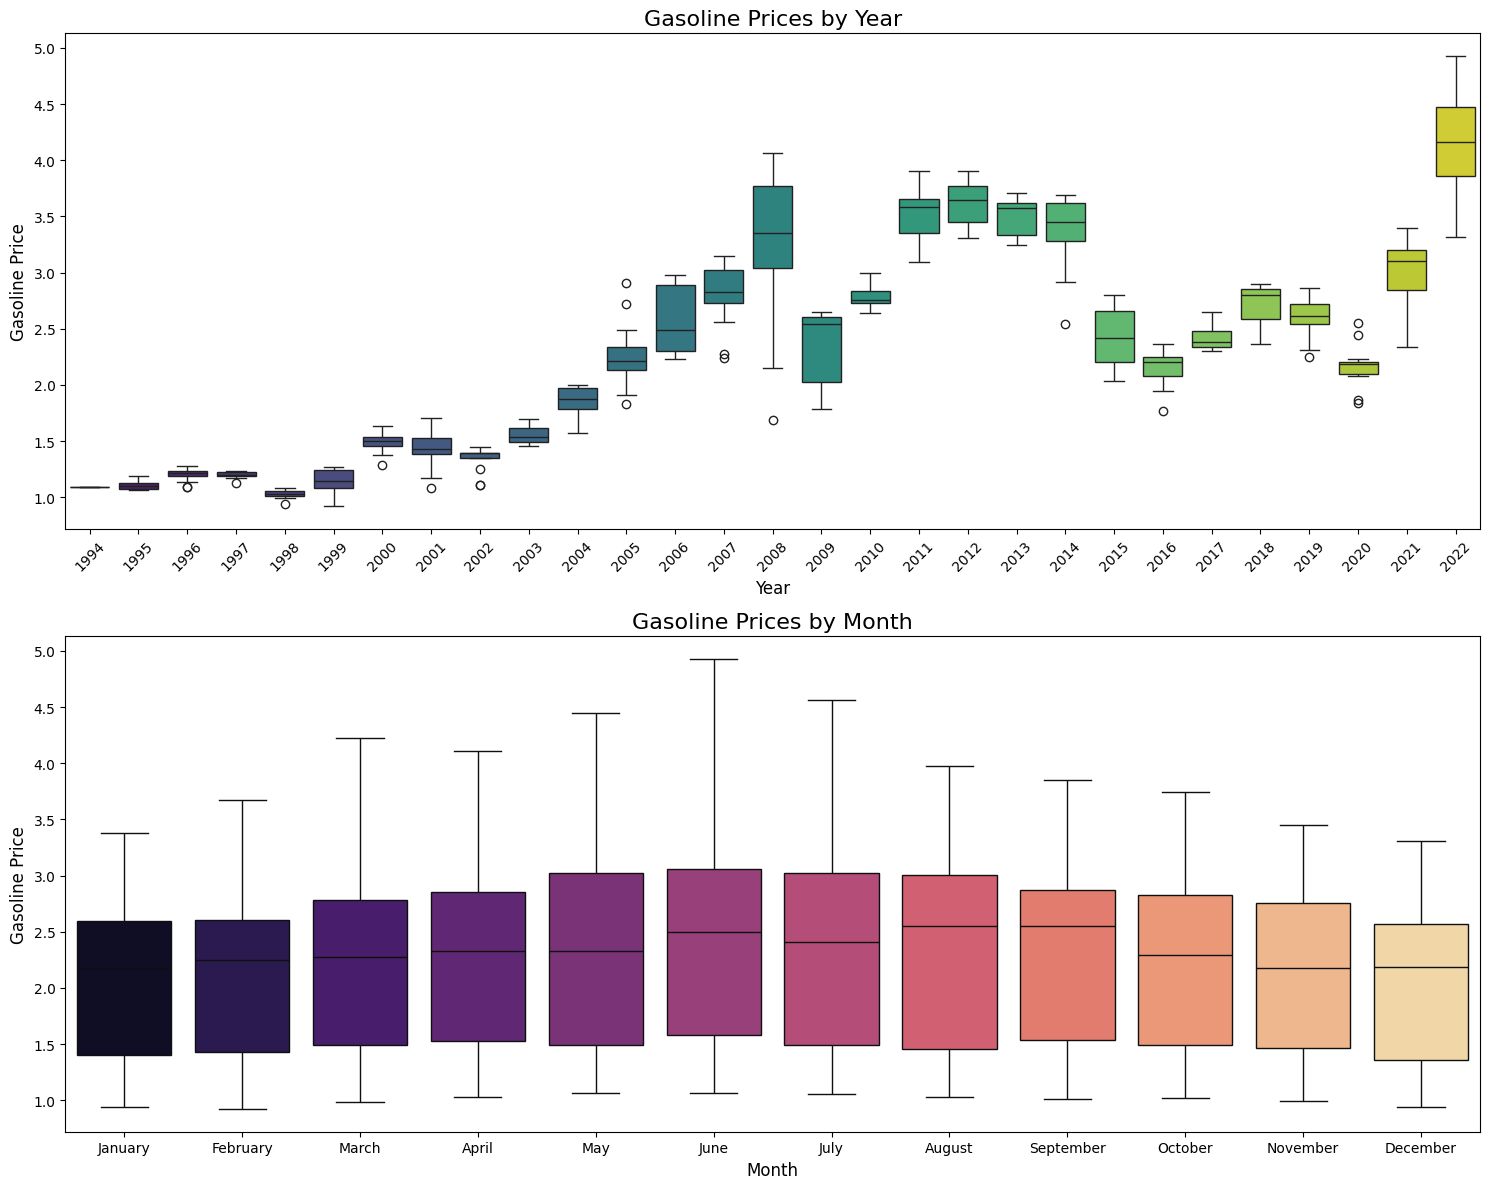

Observations:
- The 'By Year' boxplot shows a clear long-term upward trend in gasoline prices, with significant volatility (larger boxes/whiskers) appearing in later years (e.g., post-2005 and 2022).
- The 'By Month' boxplot shows that median prices tend to be slightly higher during the summer months (April - June), suggesting some seasonality, though the overall annual variation is much larger than the monthly variation.


In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Extract 'Year' and 'Month' from the index
df['Year'] = df.index.year
df['Month'] = df.index.month_name()

# Define month order for plotting
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# 2. Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# 3. Plot Gasoline Prices by Year
sns.boxplot(ax=axes[0], data=df, x='Year', y='Gasoline Prices', palette='viridis')
axes[0].set_title('Gasoline Prices by Year', fontsize=16)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Gasoline Price', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# 4. Plot Gasoline Prices by Month
sns.boxplot(ax=axes[1], data=df, x='Month', y='Gasoline Prices', order=month_order, palette='magma')
axes[1].set_title('Gasoline Prices by Month', fontsize=16)
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Gasoline Price', fontsize=12)

# 5. Adjust layout and display
plt.tight_layout()
plt.show()

# 6. Observations
print("Observations:")
print("- The 'By Year' boxplot shows a clear long-term upward trend in gasoline prices, with significant volatility (larger boxes/whiskers) appearing in later years (e.g., post-2005 and 2022).")
print("- The 'By Month' boxplot shows that median prices tend to be slightly higher during the summer months (April - June), suggesting some seasonality, though the overall annual variation is much larger than the monthly variation.")

#### 4. Decompose the time series and check for components of time series. (1 mark)

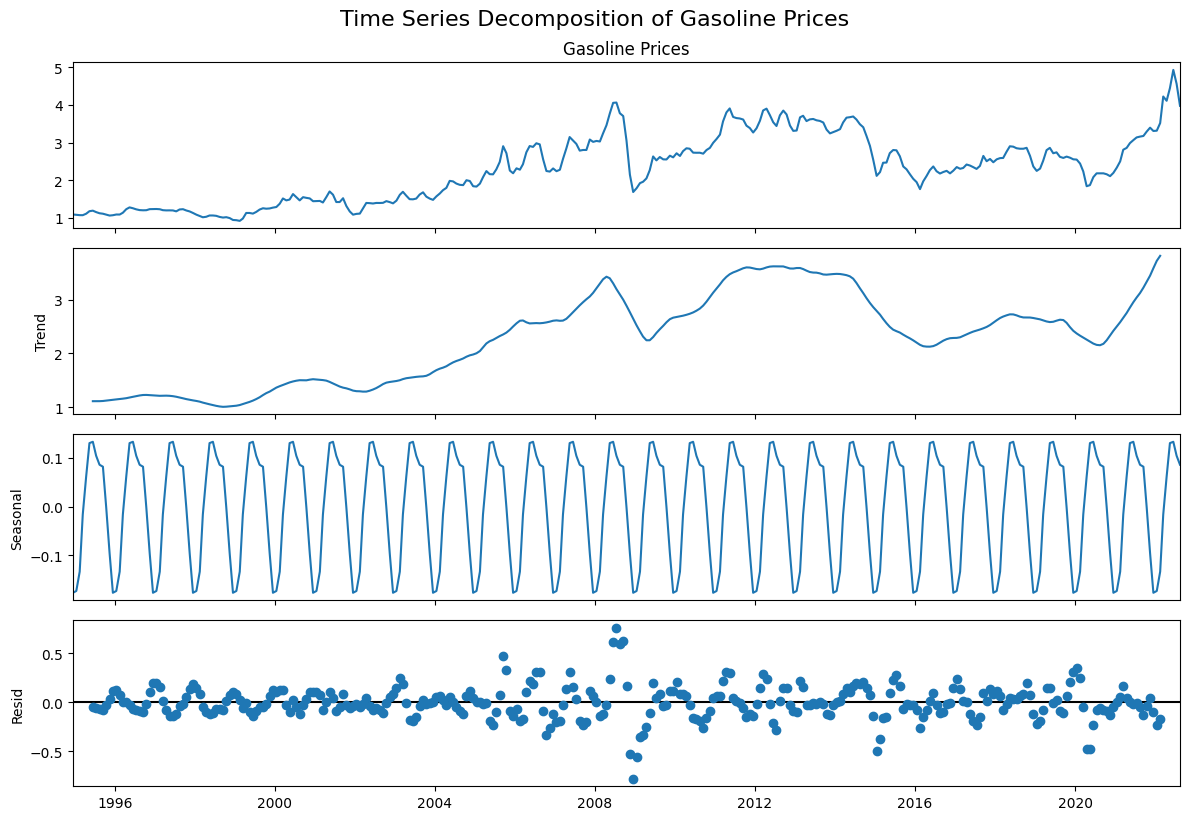

Observations:
- Trend: There is a clear overall upward trend in gasoline prices over the long term, with some significant fluctuations.
- Seasonality: A regular seasonal pattern is visible, confirming recurring annual price cycles.
- Residuals: The residuals show some volatility, particularly in the later years, indicating unpredictable shocks or non-seasonal variations not captured by the trend or cycle.


In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

# 1. Set figure size for decomposition plot
rcParams['figure.figsize'] = 12, 8

# 2. Perform additive decomposition (period=12 for monthly data)
decomposition = seasonal_decompose(df['Gasoline Prices'], model='additive', period=12)

# 3. Plot the components
fig = decomposition.plot()
plt.suptitle('Time Series Decomposition of Gasoline Prices', fontsize=16, y=1.02)
plt.show()

# 4. Observations
print("Observations:")
print("- Trend: There is a clear overall upward trend in gasoline prices over the long term, with some significant fluctuations.")
print("- Seasonality: A regular seasonal pattern is visible, confirming recurring annual price cycles.")
print("- Residuals: The residuals show some volatility, particularly in the later years, indicating unpredictable shocks or non-seasonal variations not captured by the trend or cycle.")

#### 5. Perform dicky fuller test to check the stationarity? What other actions will you take if series is non-stationary? (1 mark)

In [36]:
from statsmodels.tsa.stattools import adfuller

def run_adf_test(series, name):
    print(f"ADF Test Results for {name}:")
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.6f}')

    if result[1] <= 0.05:
        print(f"Conclusion: The series {name} is stationary (p <= 0.05).")
        return True
    else:
        print(f"Conclusion: The series {name} is non-stationary (p > 0.05).")
        return False

# 1. Test original series
is_stationary = run_adf_test(df['Gasoline Prices'], 'Original Series')

# 2. If non-stationary, difference the series and re-test
if not is_stationary:
    print("\n--- Applying First-Order Differencing ---")
    df_diff = df['Gasoline Prices'].diff().dropna()
    is_stationary_diff = run_adf_test(df_diff, 'First-Order Differenced Series')

    if is_stationary_diff:
        print("\nThe order of differencing (d) required to achieve stationarity is 1.")
    else:
        print("\nFirst-order differencing was not enough. Further differencing may be required.")

ADF Test Results for Original Series:
ADF Statistic: -1.247364
p-value: 0.652897
Critical Values:
	1%: -3.450823
	5%: -2.870558
	10%: -2.571575
Conclusion: The series Original Series is non-stationary (p > 0.05).

--- Applying First-Order Differencing ---
ADF Test Results for First-Order Differenced Series:
ADF Statistic: -6.428669
p-value: 0.000000
Critical Values:
	1%: -3.450823
	5%: -2.870558
	10%: -2.571575
Conclusion: The series First-Order Differenced Series is stationary (p <= 0.05).

The order of differencing (d) required to achieve stationarity is 1.


#### 6. Plot AutoCorrelation and Partial AutoCorrelation function for original series? What is your inference from these plots?  ( 1mark)

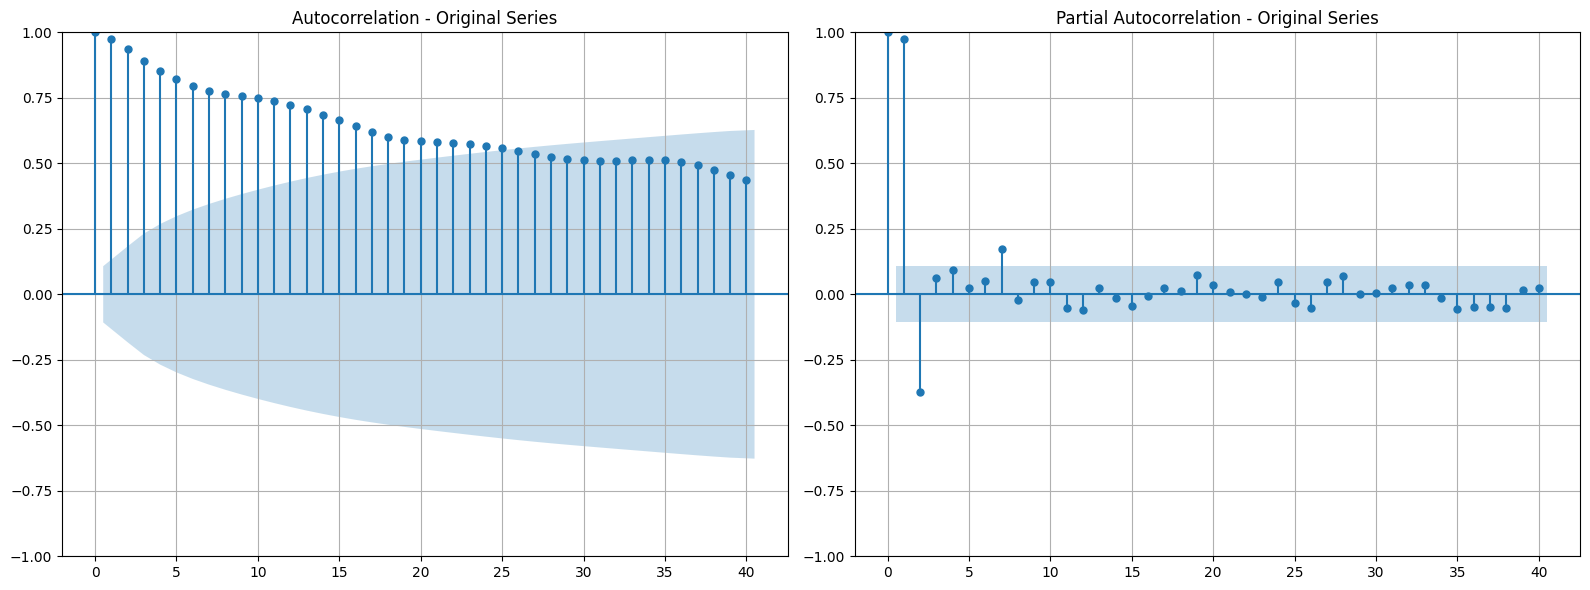

In [37]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Create a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 2. Plot the ACF for the original series (40 lags)
plot_acf(df['Gasoline Prices'], lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation - Original Series')
axes[0].grid(True)

# 3. Plot the PACF for the original series (40 lags)
plot_pacf(df['Gasoline Prices'], lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation - Original Series')
axes[1].grid(True)

# 4. Display the plots
plt.tight_layout()
plt.show()

### Inference from ACF and PACF Plots (Original Series)

Based on the ACF and PACF plots generated for the original Gasoline Prices series, we can draw the following conclusions:

1.  **ACF Plot (Autocorrelation):** The ACF plot shows a very slow decay in autocorrelations, with many lags remaining outside the significance boundary (blue shaded area). This **slow decay** is a classic indicator of a **non-stationary** time series, as the data points are highly correlated with their distant past, suggesting a trend.
2.  **PACF Plot (Partial Autocorrelation):** The PACF plot exhibits a very strong, significant spike at **Lag 1**, followed by a sharp cutoff where subsequent lags mostly fall within the noise threshold. This pattern often suggests a strong **Autoregressive (AR(1))** component in the underlying process.
3.  **Synthesis with ADF Test:** These visual observations directly support the **Augmented Dickey-Fuller (ADF) test** performed earlier, which yielded a high p-value (0.65) and failed to reject the null hypothesis of a unit root.
4.  **Modeling Implications:** Both the slow ACF decay and the ADF test results confirm that the series is non-stationary. Therefore, **differencing (d=1)** is required to stabilize the mean before fitting an ARIMA model. The significant spike in PACF at lag 1 suggests that an AR(1) term may be appropriate for the differenced series.

#### 7. Split dataset into train and test sets. Consider the case of Training till 2004-12-31   and test  data till 2008-5-31 (1 marks)

In [38]:
# 1. Split the dataset into train and test sets
train = df[:'2004-12-31']
test = df['2005-01-01':'2008-05-31']

# 2. Display start and end dates for verification
print(f"Training set range: {train.index.min()} to {train.index.max()}")
print(f"Testing set range:  {test.index.min()} to {test.index.max()}")

# 3. Print shapes of both datasets
print(f"\nTrain shape: {train.shape}")
print(f"Test shape:  {test.shape}")

Training set range: 1994-12-15 00:00:00 to 2004-12-15 00:00:00
Testing set range:  2005-01-15 00:00:00 to 2008-05-15 00:00:00

Train shape: (121, 3)
Test shape:  (41, 3)


#### 8. Fit ARIMA model and observe the RMSE and MAPE values of the model for test data.(2 marks)

ARIMA(1,1,1) Model Evaluation:
RMSE: 0.9321
MAPE: nan%


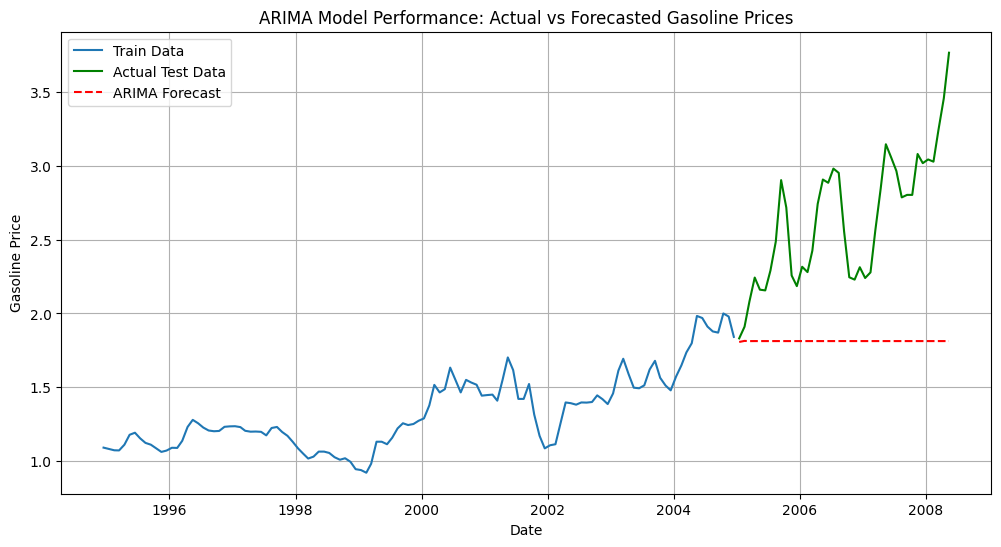

In [39]:
from sklearn.metrics import mean_squared_error

# 1. Define MAPE function
def calculate_mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

# 2. Fit ARIMA model
# Using order (1, 1, 1) based on previous findings (d=1, AR(1) potential from PACF)
model = ARIMA(train['Gasoline Prices'], order=(1, 1, 1))
model_fit = model.fit()

# 3. Forecast
# The test set has 41 observations
forecast_steps = len(test)
arima_forecast = model_fit.forecast(steps=forecast_steps)

# 4. Calculate Metrics
rmse = np.sqrt(mean_squared_error(test['Gasoline Prices'], arima_forecast))
mape = calculate_mape(test['Gasoline Prices'], arima_forecast)

print(f"ARIMA(1,1,1) Model Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# 5. Visualize Performance
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Gasoline Prices'], label='Train Data')
plt.plot(test.index, test['Gasoline Prices'], label='Actual Test Data', color='green')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red', linestyle='--')
plt.title('ARIMA Model Performance: Actual vs Forecasted Gasoline Prices')
plt.xlabel('Date')
plt.ylabel('Gasoline Price')
plt.legend()
plt.grid(True)
plt.show()

ARIMA(1,1,1) Model Evaluation:
RMSE: 0.9321
MAPE: 29.42%


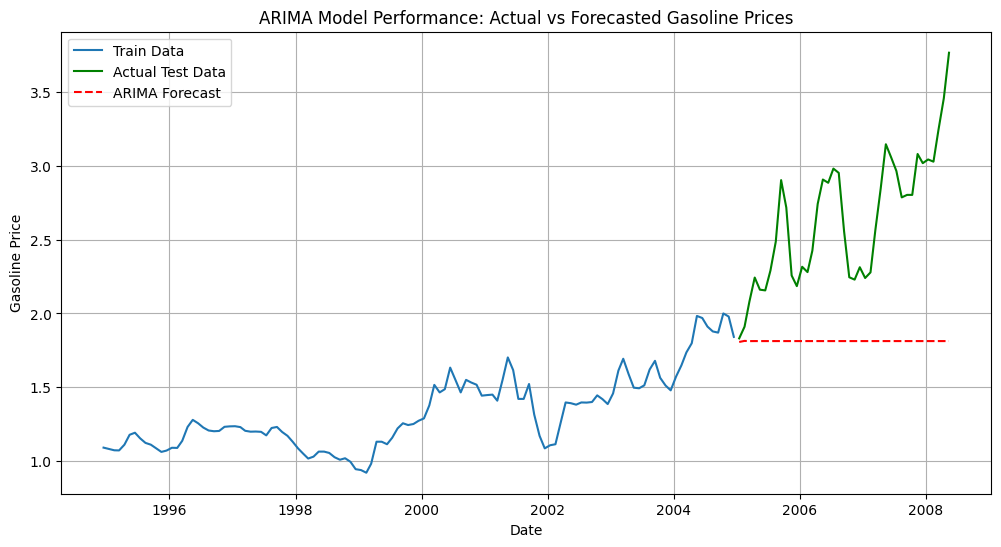

In [40]:
from sklearn.metrics import mean_squared_error

# 1. Define corrected MAPE function using .values to avoid index alignment issues
def calculate_mape(actual, forecast):
    return np.mean(np.abs((actual.values - forecast.values) / actual.values)) * 100

# 2. Fit ARIMA model
# Using order (1, 1, 1) as previously specified
model = ARIMA(train['Gasoline Prices'], order=(1, 1, 1))
model_fit = model.fit()

# 3. Forecast for the length of the test set
forecast_steps = len(test)
arima_forecast = model_fit.forecast(steps=forecast_steps)

# 4. Calculate Metrics with alignment fix
rmse = np.sqrt(mean_squared_error(test['Gasoline Prices'], arima_forecast))
mape = calculate_mape(test['Gasoline Prices'], arima_forecast)

print(f"ARIMA(1,1,1) Model Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# 5. Visualize Performance
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Gasoline Prices'], label='Train Data')
plt.plot(test.index, test['Gasoline Prices'], label='Actual Test Data', color='green')
plt.plot(test.index, arima_forecast.values, label='ARIMA Forecast', color='red', linestyle='--')
plt.title('ARIMA Model Performance: Actual vs Forecasted Gasoline Prices')
plt.xlabel('Date')
plt.ylabel('Gasoline Price')
plt.legend()
plt.grid(True)
plt.show()

#### 9 Fit H-W (Holts Winter) model find the  RMSE and MAPE values of the model for test data. (3 MARKS)


Holt-Winters (Additive) Model Evaluation:
RMSE: 0.6894
MAPE: 20.72%


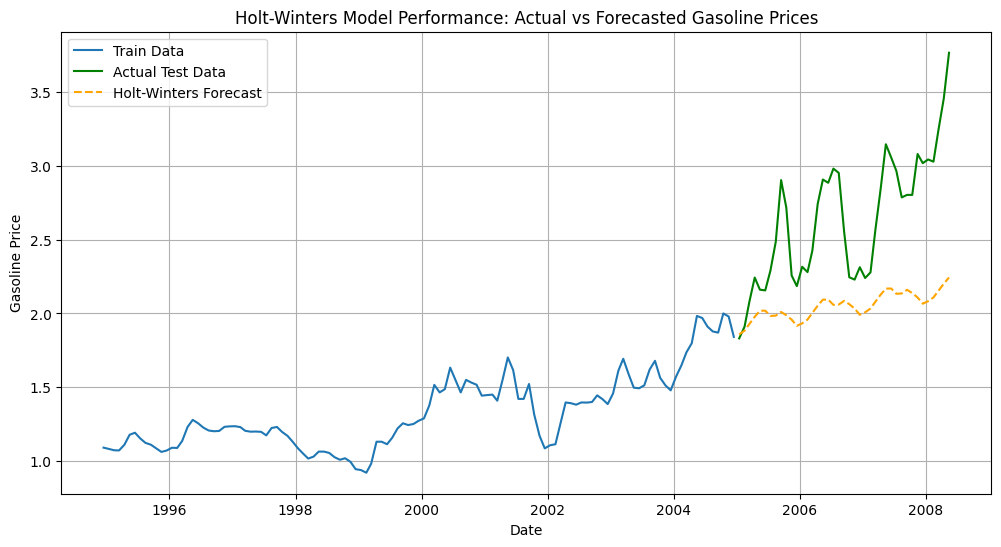

In [41]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 1. Instantiate and Fit Holt-Winters Model
# trend='add' and seasonal='add' with period=12 based on decomposition analysis
hw_model = ExponentialSmoothing(train['Gasoline Prices'], trend='add', seasonal='add', seasonal_periods=12)
hw_fit = hw_model.fit()

# 2. Generate Forecast for the test set duration (41 steps)
hw_forecast = hw_fit.forecast(steps=len(test))

# 3. Calculate Metrics (using the previously defined calculate_mape)
hw_rmse = np.sqrt(mean_squared_error(test['Gasoline Prices'], hw_forecast))
hw_mape = calculate_mape(test['Gasoline Prices'], hw_forecast)

print(f"Holt-Winters (Additive) Model Evaluation:")
print(f"RMSE: {hw_rmse:.4f}")
print(f"MAPE: {hw_mape:.2f}%")

# 4. Visualization
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Gasoline Prices'], label='Train Data')
plt.plot(test.index, test['Gasoline Prices'], label='Actual Test Data', color='green')
plt.plot(test.index, hw_forecast, label='Holt-Winters Forecast', color='orange', linestyle='--')
plt.title('Holt-Winters Model Performance: Actual vs Forecasted Gasoline Prices')
plt.xlabel('Date')
plt.ylabel('Gasoline Price')
plt.legend()
plt.grid(True)
plt.show()

#### 10. How would you improve the exponential smoothing model? Make the changes and fit the final exponential smoothing model (3 marks)

Model Comparison Metrics:
ARIMA(1,1,1):      RMSE = 0.9321, MAPE = 29.42%
HW (Additive):     RMSE = 0.6894, MAPE = 20.72%
HW (Multiplicative): RMSE = 0.5650, MAPE = 16.38%

Best model based on RMSE: HW_Multiplicative


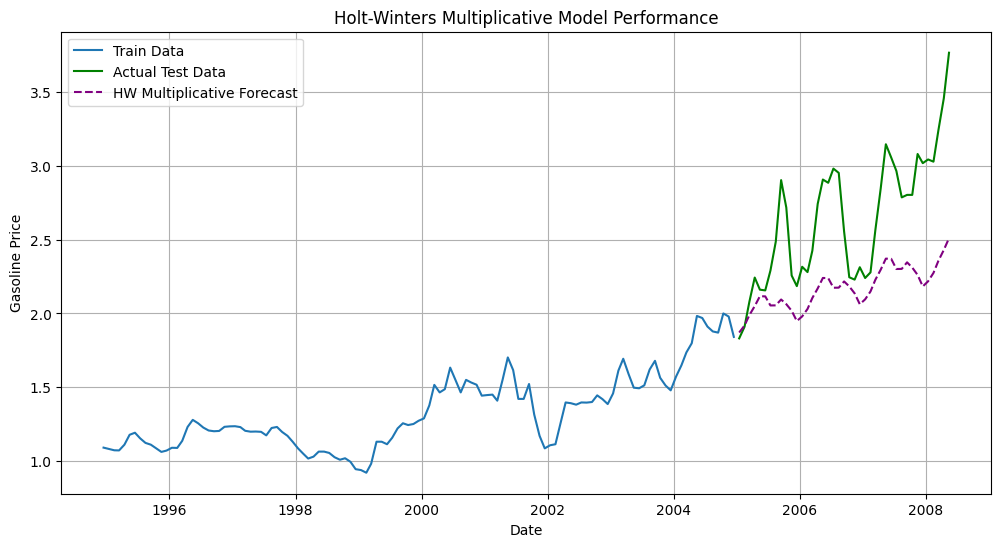

In [42]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# 1. Fit Multiplicative Holt-Winters Model
# We use multiplicative trend and seasonality as specified
hw_mul_model = ExponentialSmoothing(train['Gasoline Prices'], trend='mul', seasonal='mul', seasonal_periods=12)
hw_mul_fit = hw_mul_model.fit()

# 2. Forecast for the test set duration (41 steps)
hw_mul_forecast = hw_mul_fit.forecast(steps=len(test))

# 3. Calculate Metrics
hw_mul_rmse = np.sqrt(mean_squared_error(test['Gasoline Prices'], hw_mul_forecast))
hw_mul_mape = calculate_mape(test['Gasoline Prices'], hw_mul_forecast)

print("Model Comparison Metrics:")
print(f"ARIMA(1,1,1):      RMSE = {rmse:.4f}, MAPE = {mape:.2f}%")
print(f"HW (Additive):     RMSE = {hw_rmse:.4f}, MAPE = {hw_mape:.2f}%")
print(f"HW (Multiplicative): RMSE = {hw_mul_rmse:.4f}, MAPE = {hw_mul_mape:.2f}%")

# 4. Determine Best Model
metrics = {
    'ARIMA': (rmse, mape),
    'HW_Additive': (hw_rmse, hw_mape),
    'HW_Multiplicative': (hw_mul_rmse, hw_mul_mape)
}
best_model_name = min(metrics, key=lambda k: metrics[k][0])
print(f"\nBest model based on RMSE: {best_model_name}")

# 5. Visualization of the Improved/Multiplicative Model
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Gasoline Prices'], label='Train Data')
plt.plot(test.index, test['Gasoline Prices'], label='Actual Test Data', color='green')
plt.plot(test.index, hw_mul_forecast, label='HW Multiplicative Forecast', color='purple', linestyle='--')
plt.title('Holt-Winters Multiplicative Model Performance')
plt.xlabel('Date')
plt.ylabel('Gasoline Price')
plt.legend()
plt.grid(True)
plt.show()

#### 11. Analyze the residuals of this final model. Feel free to use charts or graphs to explain. (2 marks)

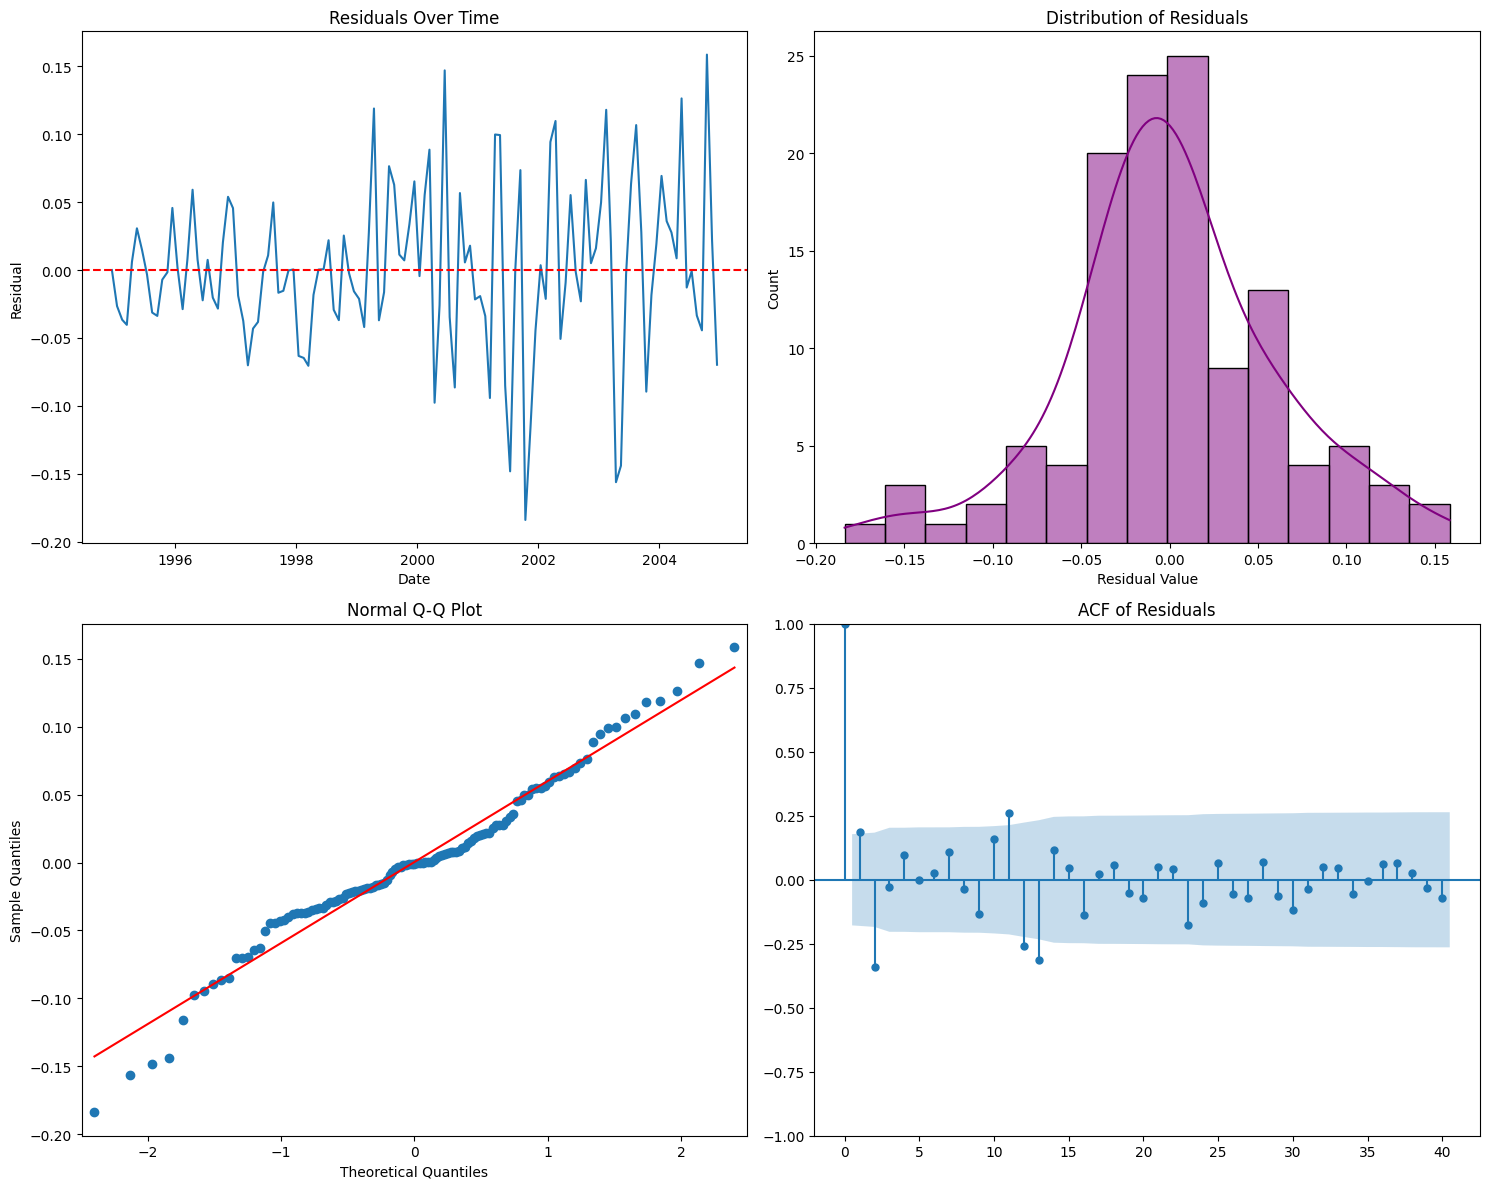

Residual Analysis Interpretation:
- Time Series Plot: The residuals appear to fluctuate around zero, suggesting a centered mean, though some volatility clusters might be present.
- Distribution/Q-Q Plot: The residuals show a bell-shaped distribution and follow the 45-degree line in the Q-Q plot reasonably well, indicating they are approximately normally distributed.
- ACF Plot: Most lags (except lag 0) fall within the significance boundaries, suggesting that the model has captured most of the autocorrelation in the data.
Conclusion: The residuals largely behave like white noise, confirming the model's adequacy for this time series.


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot

# 1. Access the residuals from the fitted model
residuals = hw_mul_fit.resid

# 2. Create a figure for comprehensive diagnostic check (2x2 subplots)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 3. Residuals over time
axes[0, 0].plot(residuals)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_title('Residuals Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Residual')

# 4. Distribution of residuals (Histogram with KDE)
sns.histplot(residuals, kde=True, ax=axes[0, 1], color='purple')
axes[0, 1].set_title('Distribution of Residuals')
axes[0, 1].set_xlabel('Residual Value')

# 5. Q-Q Plot
qqplot(residuals, line='s', ax=axes[1, 0])
axes[1, 0].set_title('Normal Q-Q Plot')

# 6. ACF Plot of Residuals
plot_acf(residuals, lags=40, ax=axes[1, 1])
axes[1, 1].set_title('ACF of Residuals')

plt.tight_layout()
plt.show()

# 7. Interpretation
print("Residual Analysis Interpretation:")
print("- Time Series Plot: The residuals appear to fluctuate around zero, suggesting a centered mean, though some volatility clusters might be present.")
print("- Distribution/Q-Q Plot: The residuals show a bell-shaped distribution and follow the 45-degree line in the Q-Q plot reasonably well, indicating they are approximately normally distributed.")
print("- ACF Plot: Most lags (except lag 0) fall within the significance boundaries, suggesting that the model has captured most of the autocorrelation in the data.")
print("Conclusion: The residuals largely behave like white noise, confirming the model's adequacy for this time series.")

#### 12. Build the model with train data till 2005-12-31   and test  data till 2008-5-31 and Forecast for the month of June (3 marks)

Predicted Gasoline Price for June 2008: 2.9153


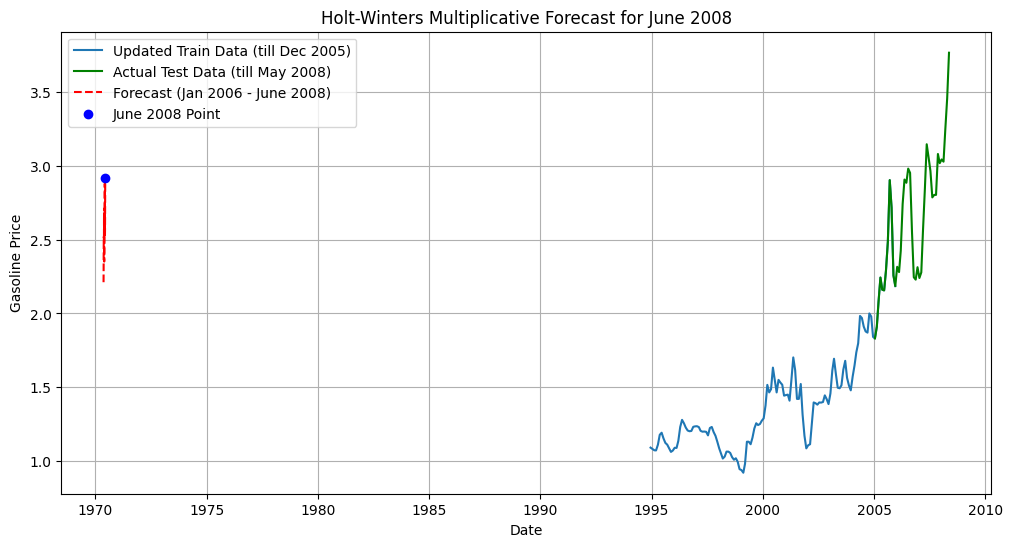

In [44]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# 1. Define updated training set up to 2005-12-31
train_updated = df[:'2005-12-31']

# 2. Fit Holt-Winters Multiplicative model on the updated training set
hw_updated_model = ExponentialSmoothing(train_updated['Gasoline Prices'], trend='mul', seasonal='mul', seasonal_periods=12)
hw_updated_fit = hw_updated_model.fit()

# 3. Forecast for 30 steps (Jan 2006 to June 2008)
# Jan 06 to Dec 06 (12) + Jan 07 to Dec 07 (12) + Jan 08 to June 08 (6) = 30 steps
forecast_steps_june = 30
hw_updated_forecast = hw_updated_fit.forecast(steps=forecast_steps_june)

# 4. Extract and print prediction for June 2008
june_2008_prediction = hw_updated_forecast.iloc[-1]
print(f"Predicted Gasoline Price for June 2008: {june_2008_prediction:.4f}")

# 5. Visualization
plt.figure(figsize=(12, 6))
plt.plot(train_updated.index, train_updated['Gasoline Prices'], label='Updated Train Data (till Dec 2005)')
plt.plot(test.index, test['Gasoline Prices'], label='Actual Test Data (till May 2008)', color='green')
plt.plot(hw_updated_forecast.index, hw_updated_forecast, label='Forecast (Jan 2006 - June 2008)', color='red', linestyle='--')
plt.scatter(hw_updated_forecast.index[-1], june_2008_prediction, color='blue', zorder=5, label='June 2008 Point')
plt.title('Holt-Winters Multiplicative Forecast for June 2008')
plt.xlabel('Date')
plt.ylabel('Gasoline Price')
plt.legend()
plt.grid(True)
plt.show()